<a href="https://colab.research.google.com/github/dymesbrunodev/Projetos-De-Estudos-Data-Science/blob/main/ai_gerador_de_imagens_e_videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
#@title Check GPU
#@markdown Run this cell to see what GPU the Colab Notebook is running. Ideally, it's not a K80 which is the slowest one.

!nvidia-smi

Wed Dec 14 12:17:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Download Models and Install/Load Packages (may take a few minutes)

!git clone https://github.com/openai/CLIP
!git clone https://github.com/CompVis/taming-transformers.git
!git clone https://github.com/minimaxir/icon-image.git
!pip install Pillow numpy fire icon_font_to_png
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install imageio-ffmpeg   
!pip install einops
!pip install imagio          
!mkdir steps

print("Downloading ImageNet 16384")

!curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1'
!curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1'

import argparse
import math
from pathlib import Path
import sys

sys.path.insert(1, '/content/taming-transformers')
sys.path.insert(1, '/content/icon-image')

from icon_image import gen_icon
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from PIL.PngImagePlugin import PngInfo
from taming.models import cond_transformer, vqgan
import taming.modules 
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from shutil import move
import os

from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


replace_grad = ReplaceGrad.apply


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None


clamp_with_grad = ClampWithGrad.apply


def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()


def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.augs = nn.Sequential(
            # K.RandomHorizontalFlip(p=0.5),
            # K.RandomVerticalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            # K.RandomSharpness(0.3,p=0.4),
            # K.RandomResizedCrop(size=(self.cut_size,self.cut_size), scale=(0.1,1),  ratio=(0.75,1.333), cropping_mode='resample', p=0.5),
            # K.RandomCrop(size=(self.cut_size,self.cut_size), p=0.5),
            K.RandomAffine(degrees=15, translate=0.1, p=0.7, padding_mode='border'),
            K.RandomPerspective(0.7,p=0.7),
            K.ColorJitter(hue=0.1, saturation=0.1, p=0.7),
            K.RandomErasing((.1, .4), (.3, 1/.3), same_on_batch=True, p=0.7),
            
)
        self.noise_fac = 0.1
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        
        for _ in range(self.cutn):

            # size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            # offsetx = torch.randint(0, sideX - size + 1, ())
            # offsety = torch.randint(0, sideY - size + 1, ())
            # cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            # cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

            # cutout = transforms.Resize(size=(self.cut_size, self.cut_size))(input)
            
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model


def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)



Cloning into 'CLIP'...
remote: Enumerating objects: 236, done.
remote: Total 236 (delta 0), reused 0 (delta 0), pack-reused 236
Receiving objects: 100% (236/236), 8.92 MiB | 9.41 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1339, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1339 (delta 0), reused 2 (delta 0), pack-reused 1335
Receiving objects: 100% (1339/1339), 409.77 MiB | 24.87 MiB/s, done.
Resolving deltas: 100% (278/278), done.
Cloning into 'icon-image'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 88 (delta 48), reused 63 (delta 23), pack-reused 0
Unpacking objects: 100% (88/88), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.4 MB/s 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551 kB 14.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 96.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 485 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement imagio (from versions: none)
ERROR: No matching distribution found for imagio
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  15.1M      0  0:01:0

In [10]:
# Fixed parameters
icon_path = "icon.png"
model_name = "vqgan_imagenet_f16_16384"
seed = 42

texts = 'robot art ' #@param {type:"string"}
width = 600 #@param {type:"integer"}
height = 600 #@param {type:"integer"}
init_image = "" #@param {type:"string"}
init_image_icon = False #@param {type:"boolean"}
if init_image_icon:
  assert os.path.exists(icon_path), "No icon has been generated from the previous cell"
  init_image = icon_path

target_images = "" #@param {type:"string"}
target_image_icon = False #@param {type:"boolean"}
if target_image_icon:
  assert os.path.exists(icon_path), "No icon has been generated from the previous cell"
  target_images = icon_path

#@markdown ---
learning_rate = 0.2 #@param {type:"slider", min:0.00, max:0.30, step:0.01}
max_steps = 200 #@param {type:"integer"}
images_interval = 50 #@param {type:"integer"}

gen_config = {
    "texts": texts,
    "width": width,
    "height": height,
    "init_image": "<icon>" if init_image_icon else init_image,
    "target_images": "<icon>" if target_image_icon else target_images,
    "learning_rate": learning_rate,
    "max_steps": max_steps,
    "training_seed": 42,
    "model": "vqgan_imagenet_f16_16384"
}

Using device: cuda:0
Using texts: ['robot art']
Using seed: 42
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 1.04MB/s]                   

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


Restored from vqgan_imagenet_f16_16384.ckpt


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 49.4MiB/s]


  0%|          | 0/200 [00:00<?, ?it/s]

i: 0, loss: 0.918427, losses: 0.918427


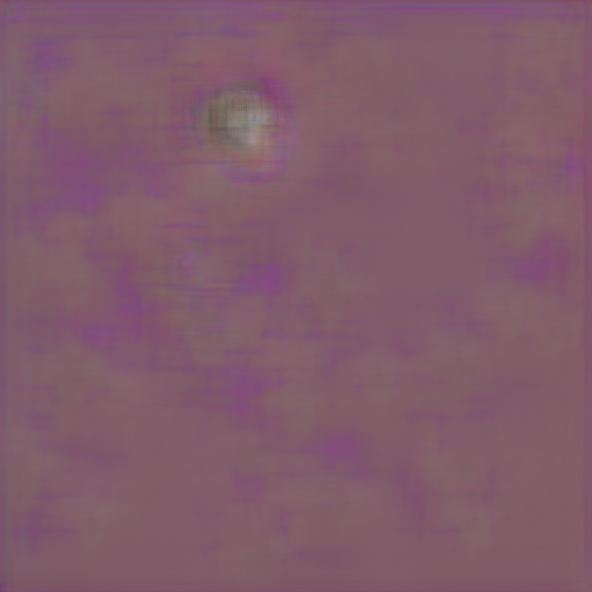

i: 50, loss: 0.787872, losses: 0.787872


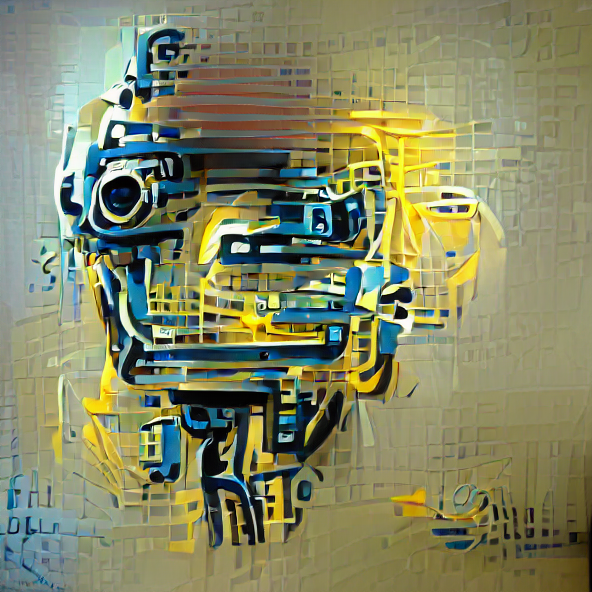

i: 100, loss: 0.768249, losses: 0.768249


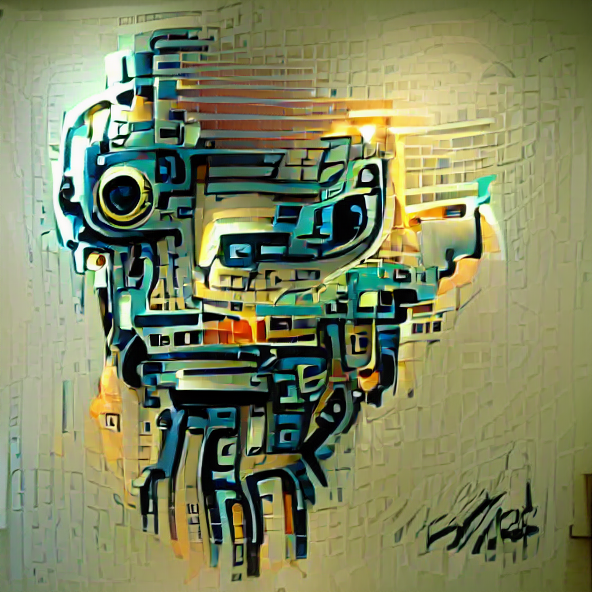

i: 150, loss: 0.741455, losses: 0.741455


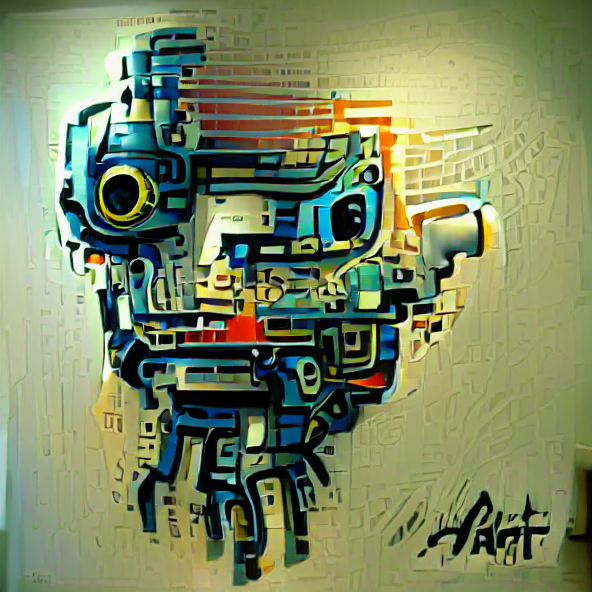

i: 200, loss: 0.788944, losses: 0.788944


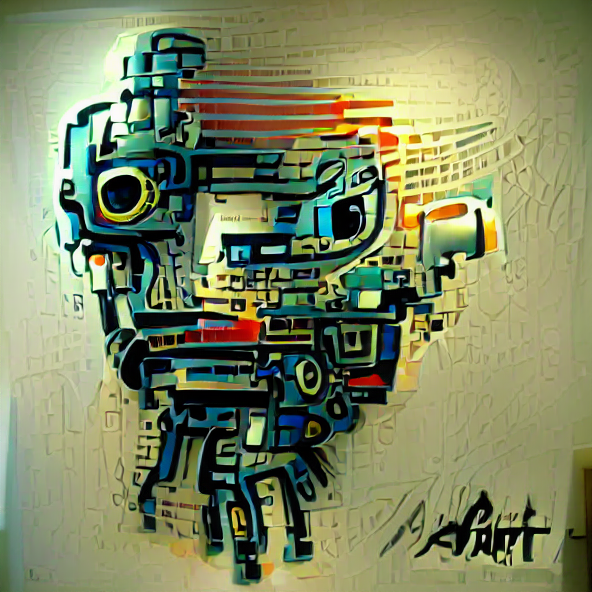

In [11]:
#@title Start AI Image Generation!

!rm -rf steps
!mkdir steps

metadata = PngInfo()
for k, v in gen_config.items():
    try:
        metadata.add_text("AI_ " + k, str(v))
    except UnicodeEncodeError:
        pass

if init_image_icon or target_image_icon:
  for k, v in icon_config.items():
    try:
        metadata.add_text("AI_Icon_ " + k, str(v))
    except UnicodeEncodeError:
        pass

model_names={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 'vqgan_openimages_f16_8192':'OpenImages 8912',
                "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", "faceshq":"FacesHQ", "sflckr":"S-FLCKR"}
name_model = model_names[model_name]     

if seed == -1:
    seed = None
if init_image == "None":
    init_image = None
if target_images == "None" or not target_images:
    model_target_images = []
else:
    model_target_images = target_images.split("|")
    model_target_images = [image.strip() for image in model_target_images]

model_texts = [phrase.strip() for phrase in texts.split("|")]
if model_texts == ['']:
    model_texts = []


args = argparse.Namespace(
    prompts=model_texts,
    image_prompts=model_target_images,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_image=init_image,
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model_name}.yaml',
    vqgan_checkpoint=f'{model_name}.ckpt',
    step_size=learning_rate,
    cutn=32,
    cut_pow=1.,
    display_freq=images_interval,
    seed=seed,
)
from urllib.request import urlopen

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if model_texts:
    print('Using texts:', model_texts)
if model_target_images:
    print('Using image prompts:', model_target_images)
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)

model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
# clock=deepcopy(perceptor.visual.positional_embedding.data)
# perceptor.visual.positional_embedding.data = clock/clock.max()
# perceptor.visual.positional_embedding.data=clamp_with_grad(clock,0,1)

cut_size = perceptor.visual.input_resolution

f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f

if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
    e_dim = 256
    n_toks = model.quantize.n_embed
    z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
else:
    e_dim = model.quantize.e_dim
    n_toks = model.quantize.n_e
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
# z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
# z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

# normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                            std=[0.229, 0.224, 0.225])

if args.init_image:
    if 'http' in args.init_image:
        img = Image.open(urlopen(args.init_image))
    else:
        img = Image.open(args.init_image)
    pil_image = img.convert('RGB')
    if pil_image.size != (width, height):
      print(f"Resizing source image to {width}x{height}")
      pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
    pil_tensor = TF.to_tensor(pil_image)
    z, *_ = model.encode(pil_tensor.to(device).unsqueeze(0) * 2 - 1)
else:
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
    # z = one_hot @ model.quantize.embedding.weight
    if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z = one_hot @ model.quantize.embed.weight
    else:
        z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
    z = torch.rand_like(z)*2
z_orig = z.clone()
z.requires_grad_(True)
opt = optim.Adam([z], lr=args.step_size)
scheduler = StepLR(opt, step_size=5, gamma=0.95)

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                std=[0.26862954, 0.26130258, 0.27577711])



pMs = []

for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for prompt in args.image_prompts:
    path, weight, stop = parse_prompt(prompt)
    img = Image.open(path)
    pil_image = img.convert('RGB')
    img = resize_image(pil_image, (sideX, sideY))
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
    embed = perceptor.encode_image(normalize(batch)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    gen = torch.Generator().manual_seed(seed)
    embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
    pMs.append(Prompt(embed, weight).to(device))

def synth(z):
    if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
    else:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    TF.to_pil_image(out[0].cpu()).save('progress.png', pnginfo=metadata)
    display.display(display.Image('progress.png'))

def ascend_txt():
    # global i
    out = synth(z)
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()
    
    result = []

    if args.init_weight:
        # result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)
        result.append(F.mse_loss(z, torch.zeros_like(z_orig)) * ((1/torch.tensor(i*2 + 1))*args.init_weight) / 2)
    for prompt in pMs:
        result.append(prompt(iii))
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    img = np.transpose(img, (1, 2, 0))
    img = Image.fromarray(img)
    # imageio.imwrite(f'./steps/{i:03d}.png', np.array(img))

    img.save(f"./steps/{i:03d}.png", pnginfo=metadata)
    return result

def train(i):
    opt.zero_grad()
    lossAll = ascend_txt()
    if i % args.display_freq == 0:
        checkin(i, lossAll)
    
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    scheduler.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

try:
    for i in tqdm(range(max_steps)):
          train(i)
    checkin(max_steps, ascend_txt())
except KeyboardInterrupt:
    pass



## Generate Video

You can generate and download a video of the AI generation you just did by running the following cell!

In [12]:
frame_rate = 30 #@param {type:"number"}

print("Rendering Video...")
result = os.system(f"ffmpeg -y -r {frame_rate} -i /content/steps/%03d.png -c:v libx264 -vf fps={frame_rate} -pix_fmt yuv420p /content/vqgan_clip.mp4")
print("Video saved at vqgan_clip.mp4!")

from google.colab import files
files.download('/content/vqgan_clip.mp4')

Rendering Video...
Video saved at vqgan_clip.mp4!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>